## HW_09


#### Imports

In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import Audio
import librosa
from sklearn import preprocessing
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split

from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import RidgeClassifier

from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay



#### Data setup and cleaning

In [16]:
data_dir = '/Users/aidan/Documents/applieddatascience/voice_clips/'
voice_clip_meta_data = pd.read_csv("/Users/aidan/Documents/applieddatascience/voice_clips_meta_data.csv")
voice_clip_meta_data.head(3)

,client_id,path,sentence,up_votes,down_votes,age,gender
0,538b6b4edc829fd43b014c5d741b9d26330a856d38b6cf...,common_voice_en_32640902.mp3,He has received two state nominations also.,2.0,0.0,seventies,male
1,538b6b4edc829fd43b014c5d741b9d26330a856d38b6cf...,common_voice_en_32640905.mp3,He played cricket for Merchiston Castle School.,2.0,0.0,seventies,male
2,538b6b4edc829fd43b014c5d741b9d26330a856d38b6cf...,common_voice_en_32640907.mp3,Her birth name is not recorded.,2.0,0.0,seventies,male


In [17]:
voice_features = pd.read_csv('/Users/aidan/Downloads/voice_features_20230404.csv')

#### Extract Delta values from dataset

In [18]:
voice_to_do = voice_features.reset_index(drop=True)

delta_stats = []
for filename in voice_features.path:
    x, sr = librosa.load(data_dir +filename, sr=None) # take the mp3's native sample rate
    mfcc = librosa.feature.mfcc(y=x, sr=sr,n_mfcc=12)
    mfcc_delta = librosa.feature.delta(mfcc).mean(axis=1)
    delta_stats.append(mfcc_delta)

delta_stats_array = np.stack(delta_stats,axis=0)
delta_features = pd.DataFrame(delta_stats, columns=['d1','d2','d3','d4','d5','d6','d7','d8','d9','d10','d11','d12'])
delta_features.to_csv("delta_features.csv", index=None)
delta_features.shape

(15006, 12)

In [19]:
voice_features.shape

(15006, 47)

In [20]:
ftable=pd.concat([voice_features,delta_features],axis=1)

In [29]:
ftable.dropna(how = 'any',inplace=True)

In [30]:
col_list_delta = ['d1','d2','d3','d4','d5','d6','d7','d8','d9','d10','d11','d12']
col_list_mfcc = ['mfcc_00', 'mfcc_01', 'mfcc_02', 'mfcc_03', 'mfcc_04', 'mfcc_05',
       'mfcc_06', 'mfcc_07', 'mfcc_08', 'mfcc_09', 'mfcc_10', 'mfcc_11',
       'mfcc_12', 'mfcc_13', 'mfcc_14', 'mfcc_15', 'mfcc_16', 'mfcc_17',
       'mfcc_18', 'mfcc_19', 'mfcc_20', 'mfcc_21', 'mfcc_22', 'mfcc_23',
       'mfcc_24']
col_list_f0 = ['f0_mean', 'f0_std','f0_var','f0_min','f0_max','f0_skew', 'f0_kurtosis']
col_list_zcr = ['zcr_mean','zcr_std','zcr_var','zcr_min','zcr_max','zcr_skew','zcr_kurtosis']

#### Classifier without Delta values

              precision    recall  f1-score   support

      female     0.9281    0.9261    0.9271      1366
        male     0.9718    0.9726    0.9722      3580

    accuracy                         0.9598      4946
   macro avg     0.9500    0.9493    0.9496      4946
weighted avg     0.9597    0.9598    0.9598      4946



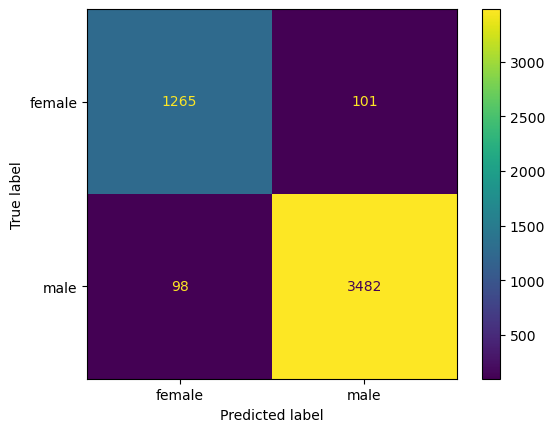

In [32]:
X = ftable[col_list_mfcc+col_list_f0+col_list_zcr]
scaler = preprocessing.MinMaxScaler().fit(X)
X = scaler.transform(X)
y = ftable.gender
X_train, X_test, y_train, y_test = \
    train_test_split(X, y, test_size=0.33, random_state=7)
rf_clf = RandomForestClassifier(max_depth=100, n_estimators=1000)
rf_clf = rf_clf.fit(X_train, y_train)
y_pred = rf_clf.predict(X_test)
print(metrics.classification_report(y_test,y_pred, digits = 4))
ConfusionMatrixDisplay.from_predictions(y_test, y_pred)

- This classifier is around 96% accurate at predicting a speakers gender based off of the mfccs, zcr values, and f0 values.

              precision    recall  f1-score   support

      female     0.9213    0.9261    0.9237      1366
        male     0.9717    0.9698    0.9708      3580

    accuracy                         0.9577      4946
   macro avg     0.9465    0.9479    0.9472      4946
weighted avg     0.9578    0.9577    0.9578      4946



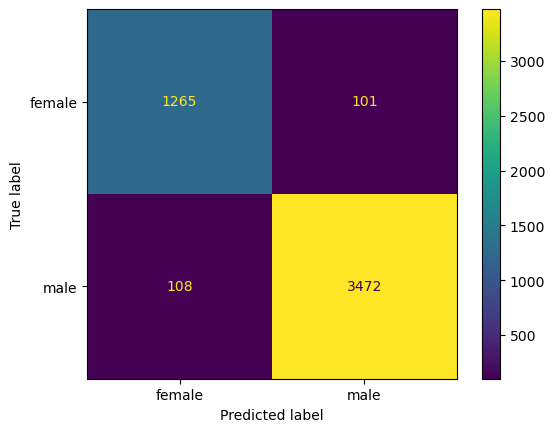

In [35]:
X = ftable[col_list_mfcc+col_list_f0+col_list_zcr+col_list_delta]
scaler = preprocessing.MinMaxScaler().fit(X)
X = scaler.transform(X)
y = ftable.gender
X_train, X_test, y_train, y_test = \
    train_test_split(X, y, test_size=0.33, random_state=7)
rf_clf = RandomForestClassifier(max_depth=100, n_estimators=1000)
rf_clf = rf_clf.fit(X_train, y_train)
y_pred = rf_clf.predict(X_test)
print(metrics.classification_report(y_test,y_pred, digits = 4))
ConfusionMatrixDisplay.from_predictions(y_test, y_pred)

- When the delta values are added, the accuracy remains very similar, but actually drop a little. This could be because delta values actually a feature of the mfcc values. Let's see what would happen if we instead replaced the mfccs of the original classifier with the delta values.

              precision    recall  f1-score   support

      female     0.9029    0.9195    0.9111      1366
        male     0.9691    0.9623    0.9657      3580

    accuracy                         0.9505      4946
   macro avg     0.9360    0.9409    0.9384      4946
weighted avg     0.9508    0.9505    0.9506      4946



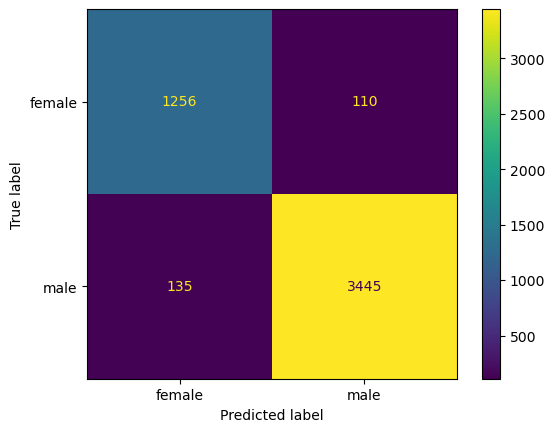

In [36]:
X = ftable[col_list_f0+col_list_zcr+col_list_delta]
scaler = preprocessing.MinMaxScaler().fit(X)
X = scaler.transform(X)
y = ftable.gender
X_train, X_test, y_train, y_test = \
    train_test_split(X, y, test_size=0.33, random_state=7)
rf_clf = RandomForestClassifier(max_depth=100, n_estimators=1000)
rf_clf = rf_clf.fit(X_train, y_train)
y_pred = rf_clf.predict(X_test)
print(metrics.classification_report(y_test,y_pred, digits = 4))
ConfusionMatrixDisplay.from_predictions(y_test, y_pred)

- This also drops a little bit in accuracy. Perhaps delta values arent super helpful when predicting voice comapred to f0 and zcr. Let's try removing them all together to be sure

              precision    recall  f1-score   support

      female     0.8977    0.9122    0.9049      1366
        male     0.9663    0.9603    0.9633      3580

    accuracy                         0.9470      4946
   macro avg     0.9320    0.9362    0.9341      4946
weighted avg     0.9473    0.9470    0.9472      4946



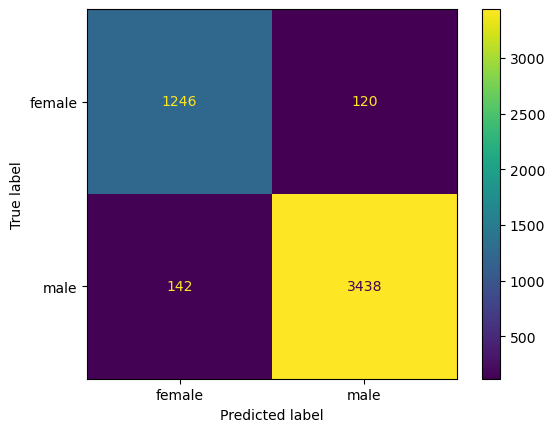

In [37]:
X = ftable[col_list_f0+col_list_zcr]
scaler = preprocessing.MinMaxScaler().fit(X)
X = scaler.transform(X)
y = ftable.gender
X_train, X_test, y_train, y_test = \
    train_test_split(X, y, test_size=0.33, random_state=7)
rf_clf = RandomForestClassifier(max_depth=100, n_estimators=1000)
rf_clf = rf_clf.fit(X_train, y_train)
y_pred = rf_clf.predict(X_test)
print(metrics.classification_report(y_test,y_pred, digits = 4))
ConfusionMatrixDisplay.from_predictions(y_test, y_pred)

- Another very miniscule drop in accuracy. This could lead us to the conclusion that neither mfcc or delta values are super important in predicting gender based off of voice data compared to other metrics like f0 and zcr.